# TP2

In [1]:
from skimage import filters, morphology, segmentation, measure, color, exposure
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import tifffile as tiff
import numpy as np
import cv2 as cv
import math
import random

In [2]:
path_pref = "C:/Users/mikho/Desktop/Vision par ordinateur/"

img_name_test = path_pref + "ImagesDeTravail/test.TIF"
img_name_grains = path_pref + "ImagesDeTravail/Grains.TIF"
img_name_image0 = path_pref + "ImagesDeTravail/image0.TIF"
img_name_gestures = path_pref + "TP2/gestures.jpg"
img_name_RondelDent = path_pref + "ImagesDeTravail/RondelDent.TIF"

img_test = tiff.imread(img_name_test)
img_grains = tiff.imread(img_name_grains)
img_gestures = cv.imread(img_name_gestures, 0)

## Thresholding

Analysing the image's histogram, a threshold value of **230** was chosen for the thresholding process because it effectively separates the predominantly white background from the gray and black objects in the image.

Text(0, 0.5, '# of pixels')

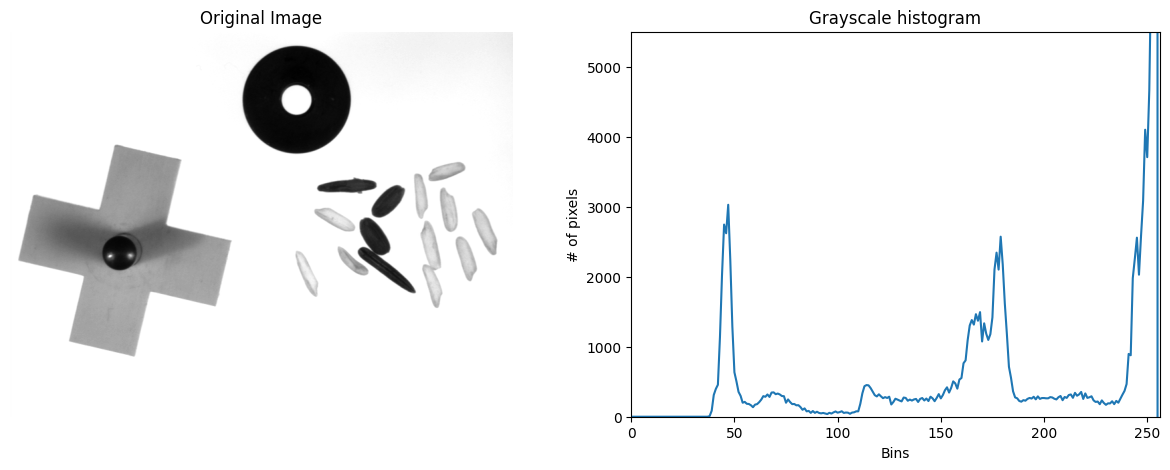

In [3]:
hist = cv.calcHist([img_test], [0], None, [256], [0, 255])

f, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].imshow(img_test, cmap="gray")
axarr[1].plot(hist)

axarr[0].set_title('Original Image')
axarr[0].axis('off')

axarr[1].axis(xmin=0,xmax=256, ymin=0,ymax=5500)
axarr[1].set_title('Grayscale histogram')
axarr[1].set_xlabel('Bins')
axarr[1].set_ylabel('# of pixels')

The manually chosen threshold value of 230 is applied to create a binary image using manual thresholding. Simultaneously, Otsu's thresholding is employed to automatically determine an optimal threshold value to binarize the image.

Manual thresholding outperforms Otsu's thresholding in this specific scenario. This is because manual thresholding effectively separates the objects from the background, while Otsu's thresholding fails to distinguish certain gray grains in the printed images, resulting in less accurate separation.

(-0.5, 751.5, 575.5, -0.5)

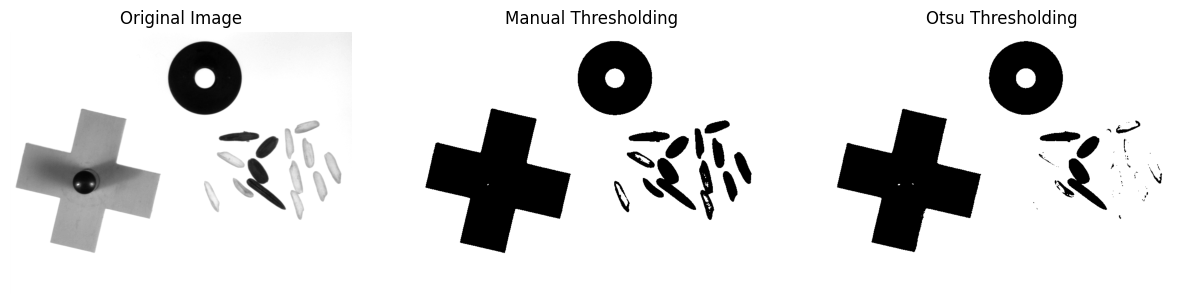

In [4]:
# Manual Thresholding
threshold_value = 230
_, manual_thresholded = cv.threshold(img_test, threshold_value, 255, cv.THRESH_BINARY)

# Otsu's Thresholding
_, otsu_thresholded = cv.threshold(img_test, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

f, axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].imshow(img_test, cmap="gray")
axarr[0].set_title('Original Image')
axarr[0].axis('off')

axarr[1].imshow(manual_thresholded, cmap="gray")
axarr[1].set_title('Manual Thresholding')
axarr[1].axis('off')

axarr[2].imshow(otsu_thresholded, cmap="gray")
axarr[2].set_title('Otsu Thresholding')
axarr[2].axis('off')

## Edge Detection and Hysteresis Thresholding

The following code performs edge detection on an input image using the Sobel gradient magnitude filter and subsequently applies hysteresis thresholding to detect edges. 

The detection of edges can be fine-tuned using the parameters *'low'* and *'high'*. Increasing the 'low' value retains more edges, while raising the 'high' value suppresses weaker edges.

In the resulting 'Hysteresis Threshold' image, fewer edges can be observed compared to the 'Low Threshold' image. This is because the Hysteresis Thresholding method preserves only the edges with a strong connection to the initial edge candidates based on the 'high' threshold. It effectively filters out weaker or isolated edge pixels.


(-0.5, 751.5, 575.5, -0.5)

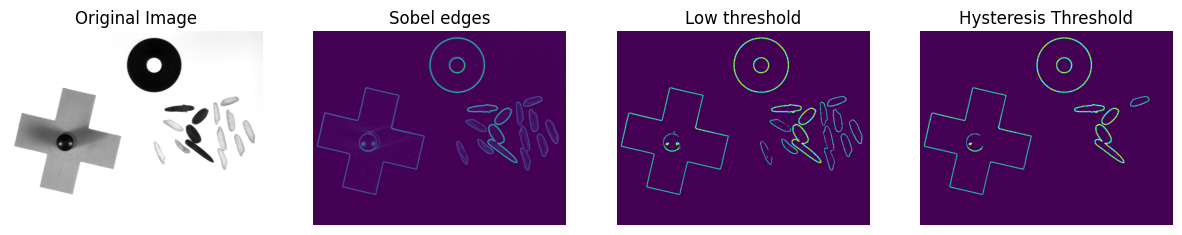

In [5]:
# Apply gradient magnitude filter for edge detection
edges = filters.sobel(img_test)

# Define the low and high thresholds
low = 0.1
high = 0.25

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)

# Perform hysteresis thresholding
hyst = filters.apply_hysteresis_threshold(edges, low, high)

f, axarr = plt.subplots(1,4,figsize=(15,5))
axarr[0].imshow(img_test, cmap="gray")
axarr[0].set_title('Original Image')
axarr[0].axis('off')

axarr[1].imshow(edges)
axarr[1].set_title('Sobel edges')
axarr[1].axis('off')

axarr[2].imshow(lowt)
axarr[2].set_title('Low threshold')
axarr[2].axis('off')

axarr[3].imshow(hyst)
axarr[3].set_title('Hysteresis Threshold')
axarr[3].axis('off')

## Other methods

Visual representation of how different thresholding techniques affect the image.

The **Mean** method demonstrated the most effective performance in separating objects from the white background. 

Methods **Triangle** and **Yen** exhibited suboptimal results, as they also selected unnecessary background areas that did not belong to the objects of interest. 

Methods **Isodata**, **Li**, **Minimum**, and **Otsu** faced challenges in accurately identifying the gray grains within the image, which might be attributed to the varying levels of contrast and distribution of pixel values in the grayscale image. 

Overall, the choice of thresholding method should be tailored to the specific characteristics of the image and the objects that are intended to be isolated to achieve the best results.

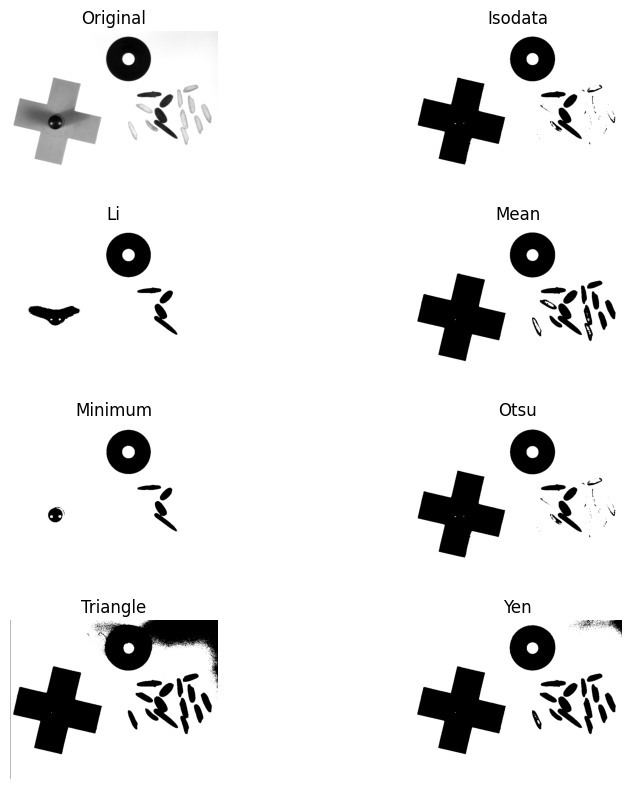

In [6]:
fig, ax = filters.try_all_threshold(img_test, figsize=(10, 8), verbose=False)
plt.show()

## Binary image analysis


After a visual analysis of the thresholding methods, the Triangle method was selected to create a binary version of the image, because it separates all the objects in the image from the background. 

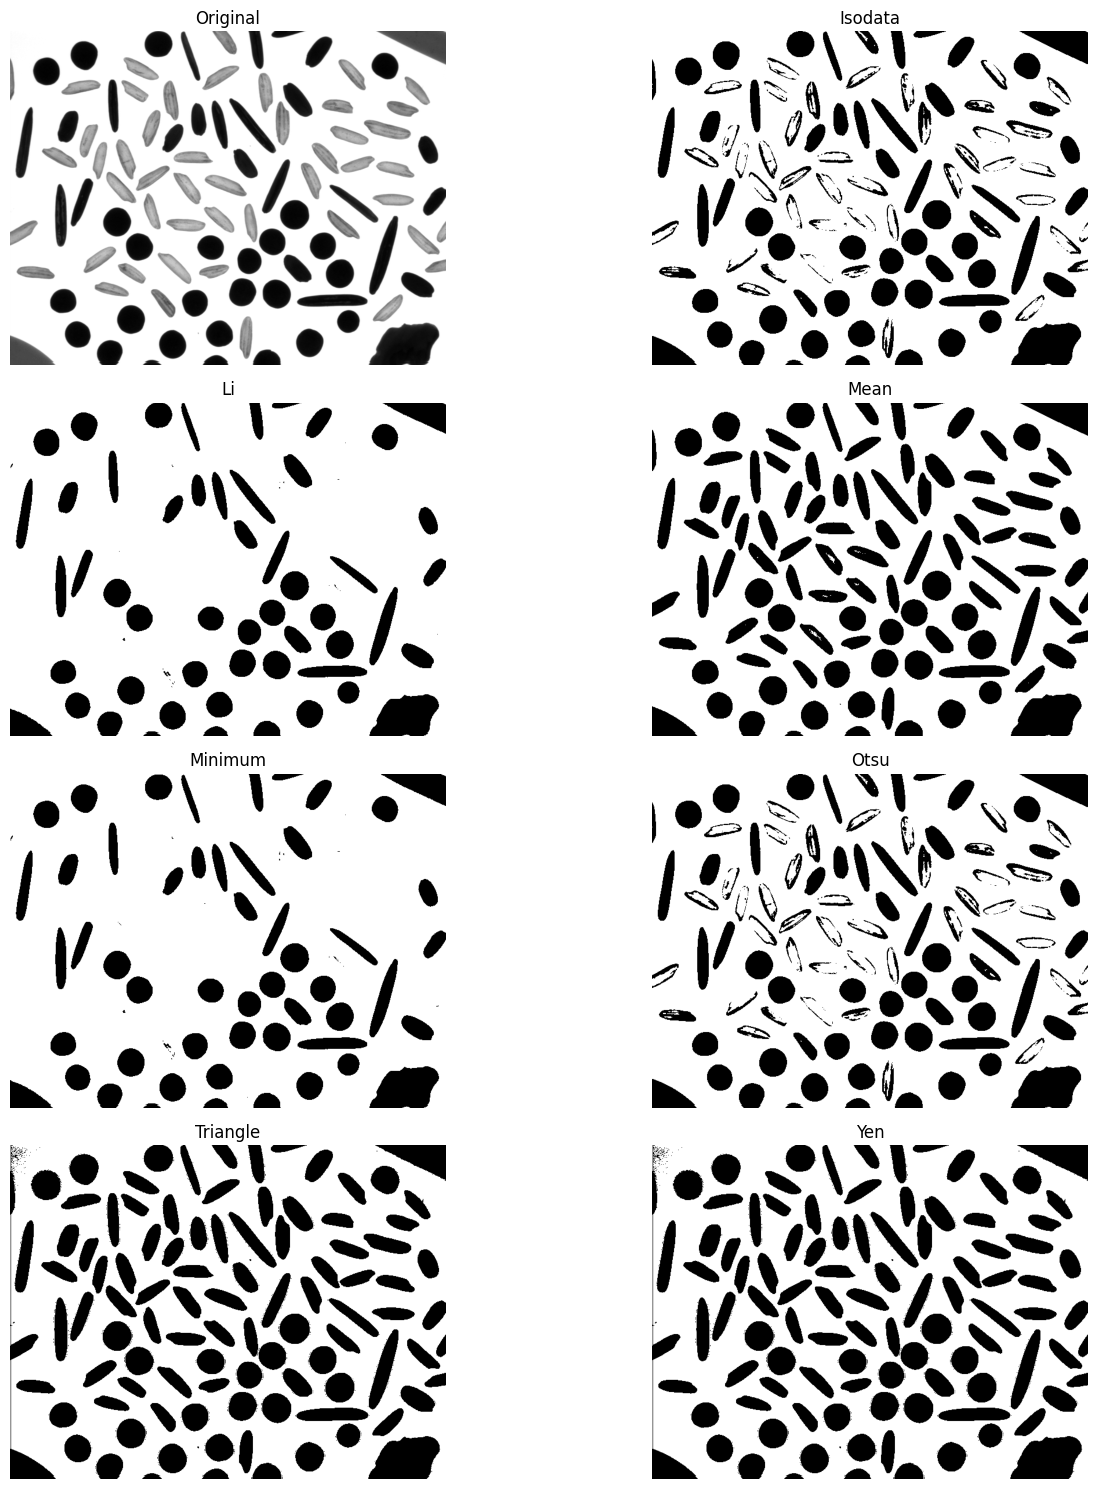

In [7]:
fig, ax = filters.try_all_threshold(img_grains, figsize=(15, 15), verbose=False)
plt.show()

This binary image will be used for subsequent morphology operations and segmentation.

(-0.5, 751.5, 575.5, -0.5)

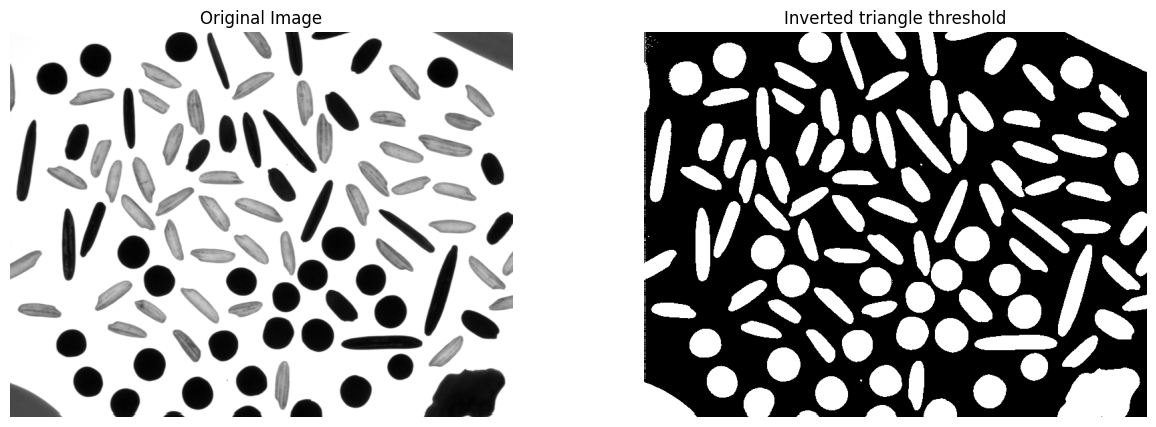

In [8]:
thresh = filters.threshold_triangle(img_grains)
binary_grains = img_grains < thresh

f, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].imshow(img_grains, cmap="gray")
axarr[0].set_title('Original Image')
axarr[0].axis('off')

axarr[1].imshow(binary_grains, cmap="gray")
axarr[1].set_title('Inverted triangle threshold')
axarr[1].axis('off')

## Morphology operations

The following code demonstrates the application of various morphology operations (erosion, dilation, opening, and closing) for different numbers of iterations on a binary image, displaying the results in a grid of subplots.

After a visual analysis, the **Erosion operation**(1 itteration) proves to be effective at removing noise while preserving the objects in the binary image. 

Erosion is well-suited for this task because it erodes away small isolated regions, effectively reducing noise, while maintaining the overall shape and integrity of the grains. 

In contrast, Dilation introduces additional noise.

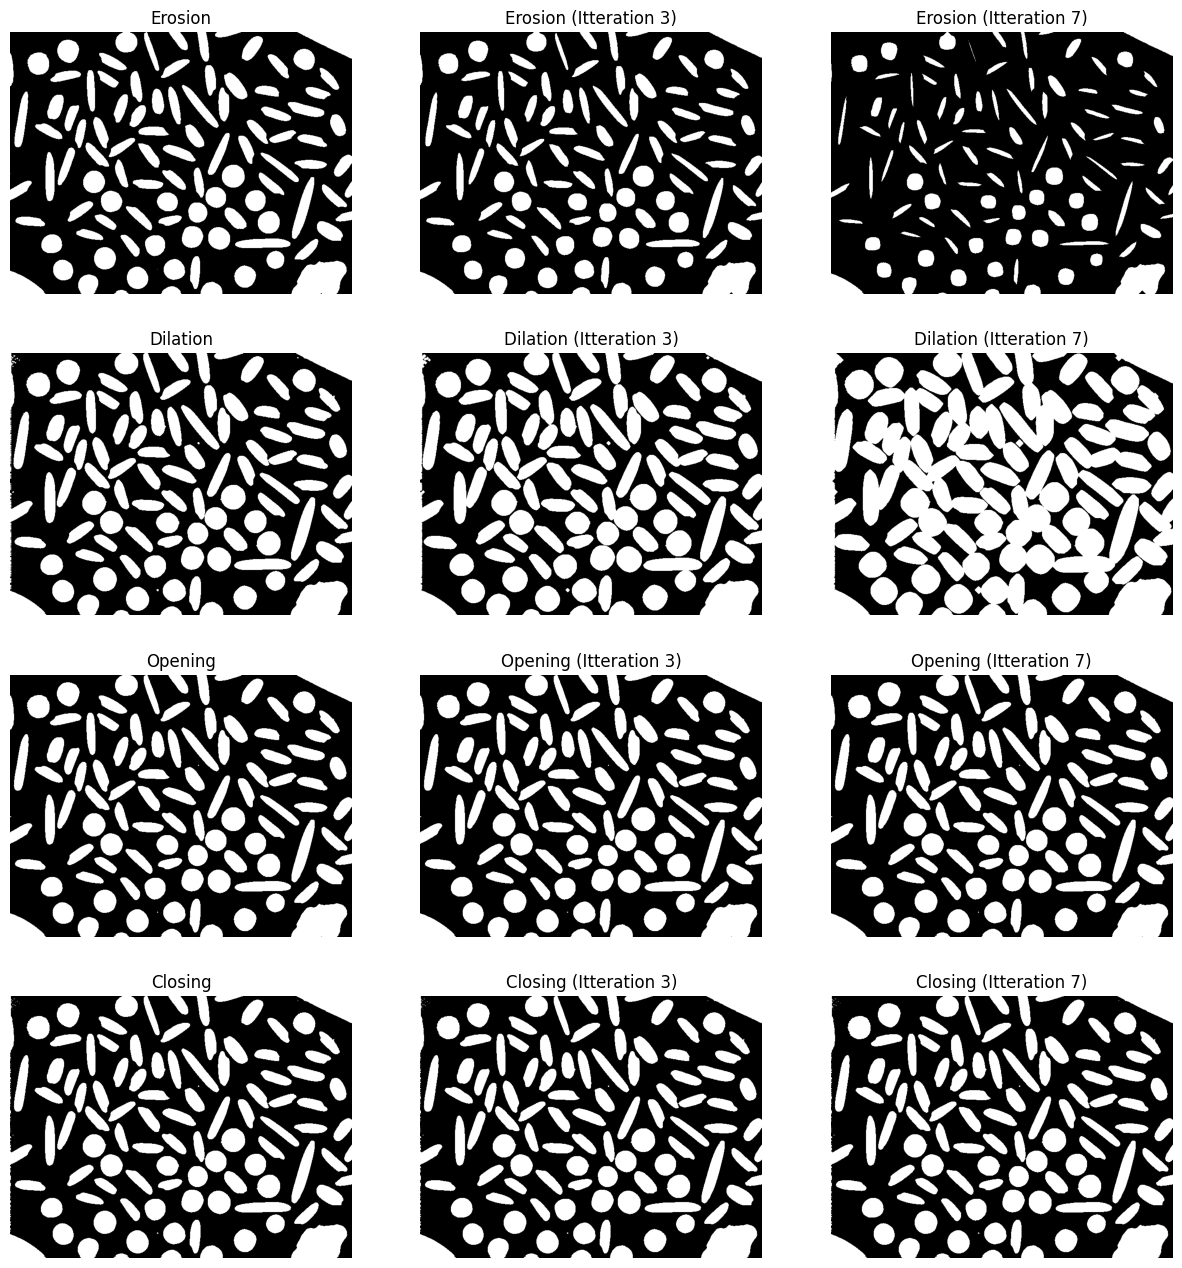

In [9]:
# Define the number of times to apply each morphology operation
cycles = [1, 3, 7]

# Create subplots to visualize the results
fig, axarr = plt.subplots(4, 3, figsize=(15, 16))

# Define morphology operations
operations = [morphology.erosion, morphology.dilation, morphology.opening, morphology.closing]

# Iterate through operations and cycles
for i, operation in enumerate(operations):
    for j, cycle in enumerate(cycles):
        # Apply the operation for the specified number of cycles
        processed_image = binary_grains.copy()
        for _ in range(cycle):
            processed_image = operation(processed_image)

        # Display the result
        axarr[i, j].imshow(processed_image, cmap="gray")
        axarr[i, j].set_title(f'{operation.__name__.capitalize()} (Itteration {cycle})')
        axarr[i, j].axis('off')

# Set titles for the operation columns
axarr[0, 0].set_title('Erosion')
axarr[1, 0].set_title('Dilation')
axarr[2, 0].set_title('Opening')
axarr[3, 0].set_title('Closing')

plt.show()

Following code demonstrtes how different footprints and the number of iterations impact the degree of erosion, affecting the image's content and shape.

Circular footprints lead to smoother erosion, while rectangular or diamond-shaped footprints create different rectangular or diamond-shaped objects effects, depending on the number of cycles.

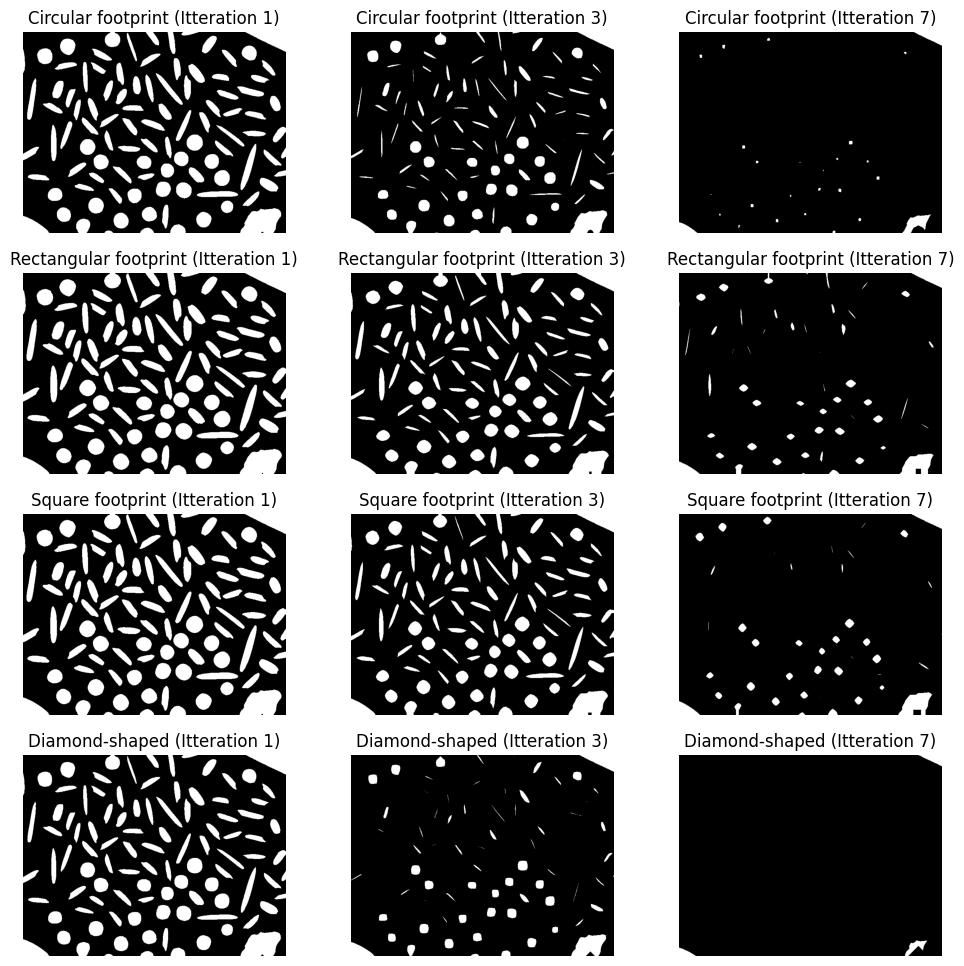

In [10]:
# Create a list of different footprints (structuring elements) and corresponding descriptions
footprints = [
    (morphology.disk(3), "Circular footprint"),
    (morphology.rectangle(5, 3), "Rectangular footprint"),
    (morphology.square(4), "Square footprint"),
    (morphology.diamond(4), "Diamond-shaped"),
]

# Number of erosion loop cycles
cycles = [1, 3, 7]

# Create subplots to visualize erosion with different footprints
fig, axes = plt.subplots(len(footprints), len(cycles), figsize=(12, 12))

for i, (footprint, footprint_description) in enumerate(footprints):
    for j, cycle in enumerate(cycles):
        # Apply erosion with the selected footprint and cycle count
        eroded_image = binary_grains.copy()
        for _ in range(cycle):
            eroded_image = morphology.erosion(eroded_image, footprint)

        # Display the result
        ax = axes[i, j]
        ax.imshow(eroded_image, cmap='gray')
        ax.set_title(f'{footprint_description} (Itteration {cycle})')
        ax.axis('off')

plt.show()

## Additional morphology operations

### Hit or Miss

Following code generates a random binary image with a scattering of white pixels on a black background and uses a predefined kernel to perform the Hit-or-Miss operation to detect the presence of specific pattern within the image. The results are displayed to visualize the detected pattern.

(-0.5, 19.5, 19.5, -0.5)

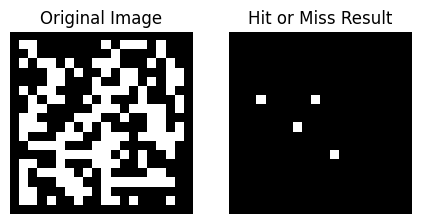

In [11]:
# Create a blank 20x20 image
image = np.zeros((20, 20), dtype=np.uint8)

num_points = 200
points = [(random.randint(1, 18), random.randint(1, 18)) for _ in range(num_points)]

for point in points:
    image[point[0], point[1]] = 255

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

kernels = [
    np.array([
        [0, 1, 0],
        [1, -1, 1],
        [0, 1, 0]
    ], dtype="int")
    
]

# Detect patterns using Hit-or-Miss for each kernel
detected_patterns = np.zeros(image.shape, dtype="uint8")
for kernel in kernels:
    output_image = cv.morphologyEx(image, cv.MORPH_HITMISS, kernel)
    detected_patterns |= output_image


# Display the results
plt.subplot(232)
plt.imshow(detected_patterns, cmap='gray')
plt.title('Hit or Miss Result')
plt.axis('off')

### Skeletonize

Following code visually demonstrates a sequence of image processing steps, including triangle thresholding, skeletonization, and erosion, to progressively simplify and emphasize the structural details of gestures in the original image.

(-0.5, 739.5, 653.5, -0.5)

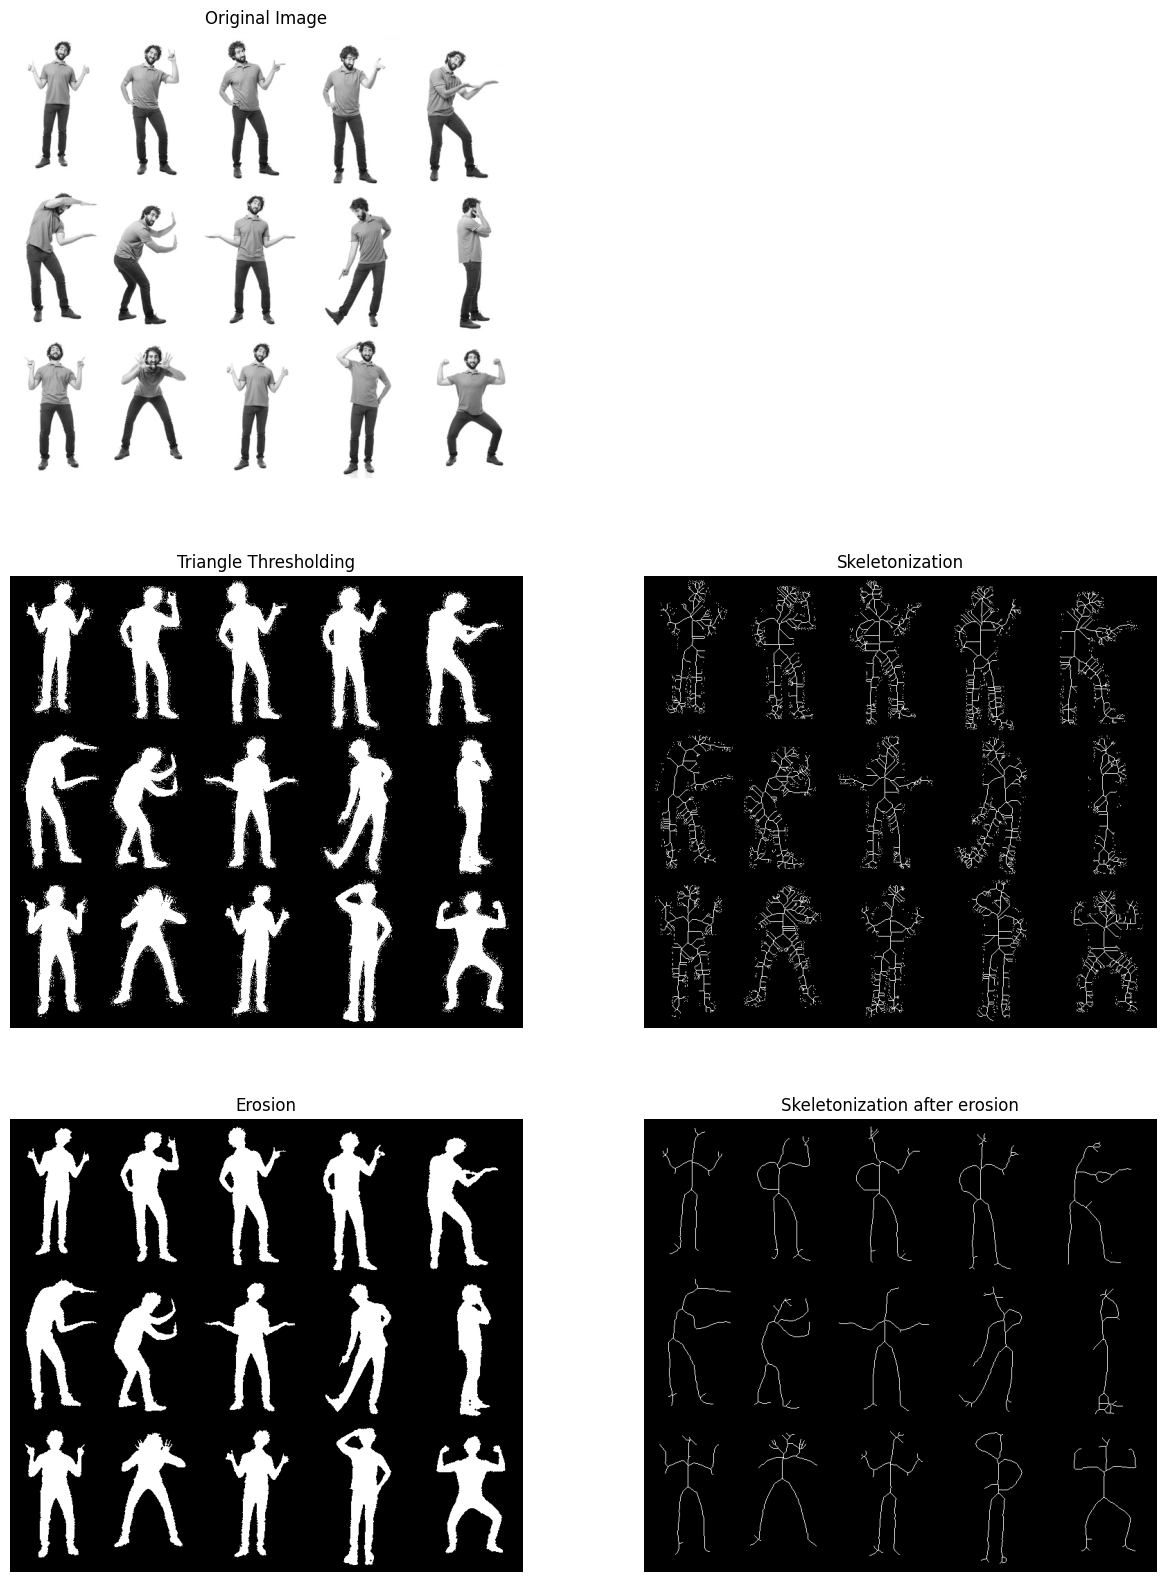

In [12]:
# Display the original image
plt.figure(figsize=(15, 20))
plt.subplot(321)
plt.imshow(img_gestures, cmap="gray")
plt.title('Original Image')
plt.axis('off')

# Triangle Thresholding
thresh = filters.threshold_triangle(img_gestures)
binary_gestures = img_gestures < thresh
plt.subplot(323)
plt.imshow(binary_gestures, cmap="gray")
plt.title('Triangle Thresholding')
plt.axis('off')

# Skeletonization
skeleton = morphology.skeletonize(binary_gestures)
plt.subplot(324)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonization')
plt.axis('off')

# Erosion
eroded = morphology.erosion(binary_gestures)
plt.subplot(325)
plt.imshow(eroded, cmap="gray")
plt.title('Erosion')
plt.axis('off')

# Skeletonization
skeleton = morphology.skeletonize(eroded)
plt.subplot(326)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonization after erosion')
plt.axis('off')


### Morphological thinning

Thinning and skeletonization operations are used in image processing to simplify and extract essential structural information from binary images, often applied in tasks like pattern recognition and character recognition to reduce the representation to its core features for analysis and matching.

Following code demonstrates the application of skeletonization, full thinning, and partial thinning to an eroded image, revealing different levels of simplification in the representation of the image's structural features, with skeletonization preserving more details, full thinning further reducing the image, and partial thinning allowing a controlled level of thinning.

(-0.5, 739.5, 653.5, -0.5)

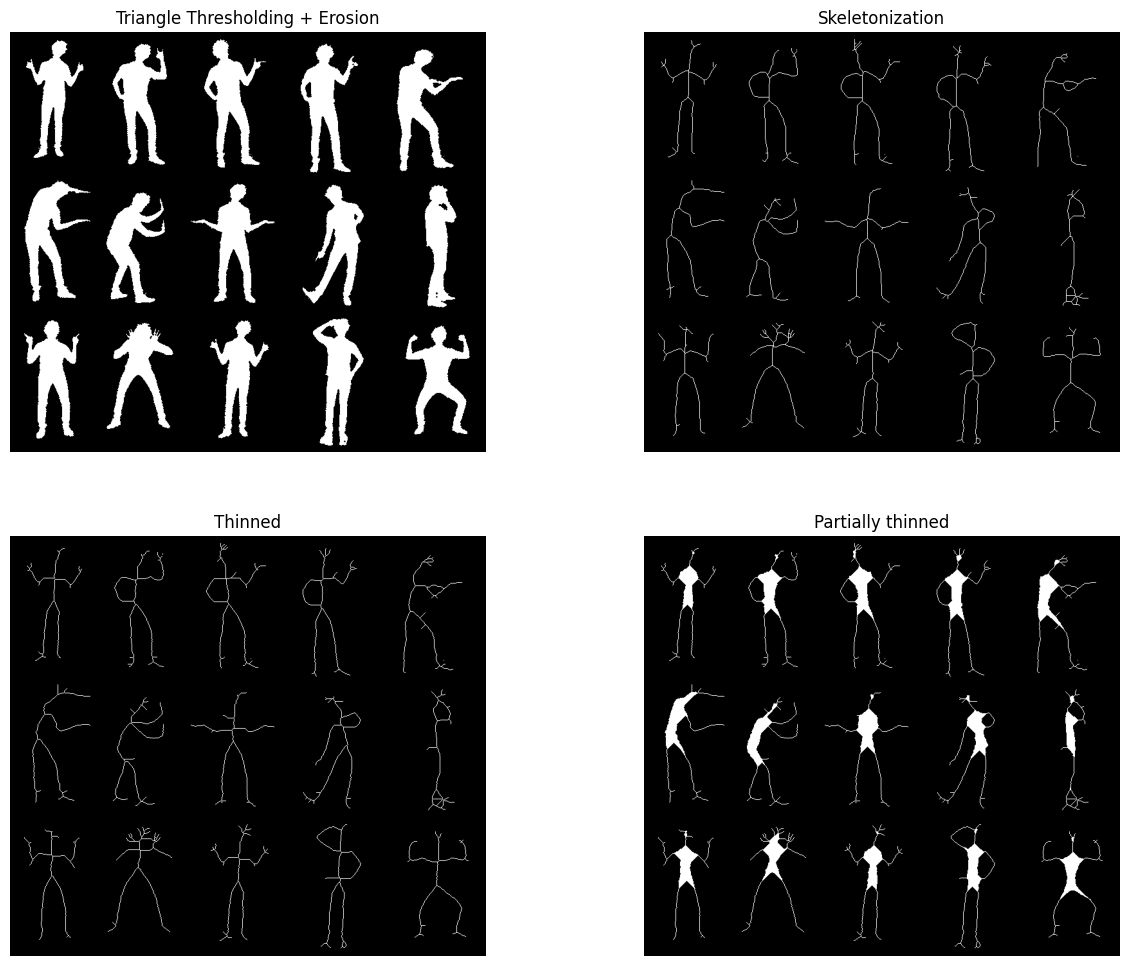

In [13]:
skeleton = morphology.skeletonize(eroded)

thinned = morphology.thin(eroded)
thinned_partial = morphology.thin(eroded, max_num_iter=10)

plt.figure(figsize=(15, 12))
plt.subplot(221)
plt.imshow(eroded, cmap="gray")
plt.title('Triangle Thresholding + Erosion')
plt.axis('off')

plt.subplot(222)
plt.imshow(skeleton, cmap="gray")
plt.title('Skeletonization')
plt.axis('off')

plt.subplot(223)
plt.imshow(thinned, cmap="gray")
plt.title('Thinned')
plt.axis('off')

plt.subplot(224)
plt.imshow(thinned_partial, cmap="gray")
plt.title('Partially thinned')
plt.axis('off')


## Distance Transform

Distance transform used to measure the spatial relationships between objects or regions in an image, facilitating tasks such as object detection, shape analysis, pattern recognition, and path planning.

After applying the Distance Transform, each pixel's intensity represents the shortest distance from that pixel to the nearest boundary or edge in the original image.

(-0.5, 751.5, 575.5, -0.5)

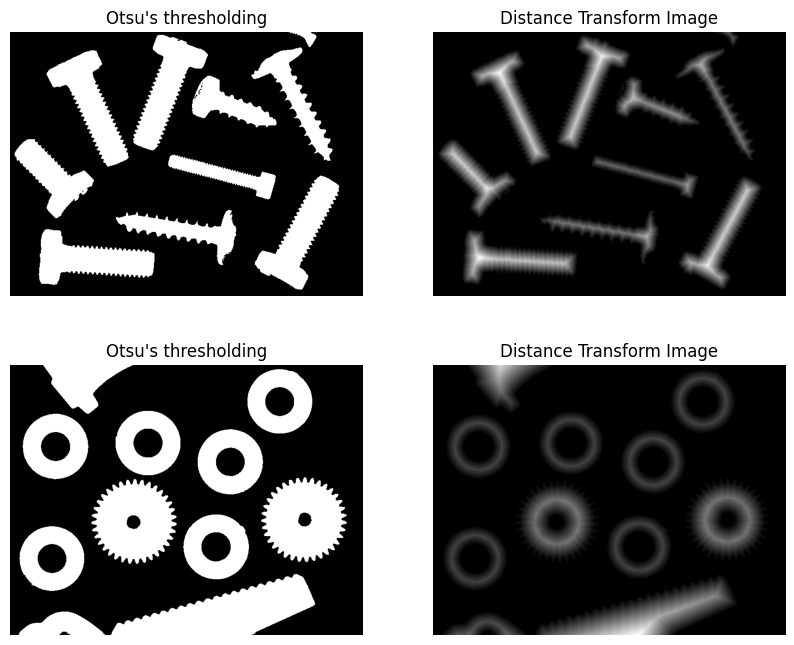

In [14]:
img1 = cv.imread(img_name_image0)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

img2 = cv.imread(img_name_RondelDent)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# Apply Otsu's thresholding
_, bw1 = cv.threshold(img1, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
bw1 = ~bw1

_, bw2 = cv.threshold(img2, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
bw2 = ~bw2

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(bw1, cmap="gray")
plt.title('Otsu\'s thresholding')
plt.axis('off')

plt.subplot(223)
plt.imshow(bw2, cmap="gray")
plt.title('Otsu\'s thresholding')
plt.axis('off')

# Distance transform
dist1 = cv.distanceTransform(bw1, cv.DIST_L2, 3)
dist2 = cv.distanceTransform(bw2, cv.DIST_L2, 3)

# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist1, dist1, 0, 1.0, cv.NORM_MINMAX)
cv.normalize(dist2, dist2, 0, 1.0, cv.NORM_MINMAX)

plt.subplot(222)
plt.imshow(dist1, cmap="gray")
plt.title('Distance Transform Image')
plt.axis('off')

plt.subplot(224)
plt.imshow(dist2, cmap="gray")
plt.title('Distance Transform Image')
plt.axis('off')

## Reconstruction

### Filling holes and finding peaks

Morphological reconstruction is performed to fill holes in the image, followed by a reconstruction to extract peaks.

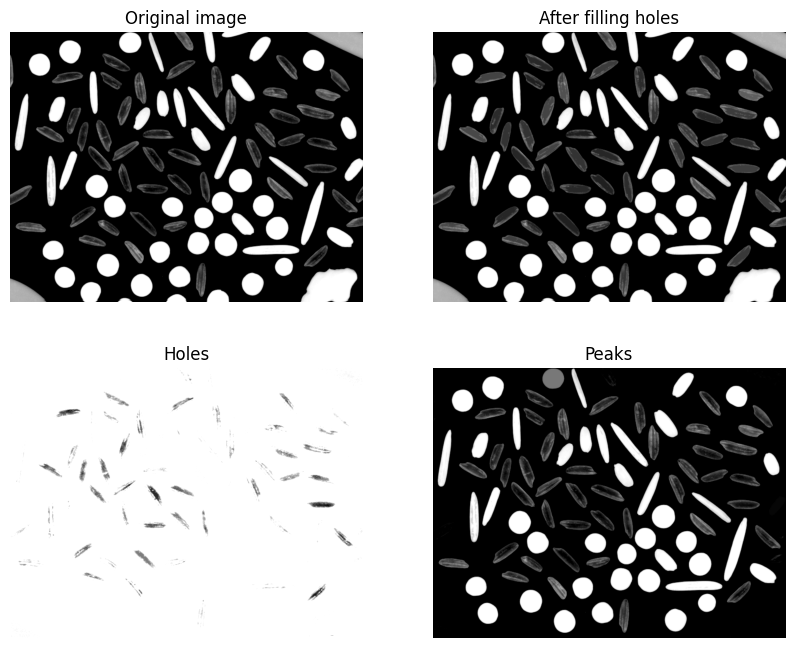

In [15]:
image = exposure.rescale_intensity(img_grains, in_range=(50, 200))
image = ~image

seed = np.copy(image)
seed[1:-1, 1:-1] = image.max()
mask = image

filled = morphology.reconstruction(seed, mask, method='erosion')
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = morphology.reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filled, cmap='gray')
ax[1].set_title('After filling holes')
ax[1].axis('off')

ax[2].imshow(image-filled, cmap='gray')
ax[2].set_title('Holes')
ax[2].axis('off')

ax[3].imshow(image-rec, cmap='gray')
ax[3].set_title('Peaks')
ax[3].axis('off')
plt.show()

### Deleting objects

The following code performs two types of reconstruction, erosion and dilation, to process the binary image, effectively removing small objects while preserving grain structures, and subsequently clears the objects touching the image borders, providing a refined and segmented image for further analysis.

(-0.5, 751.5, 575.5, -0.5)

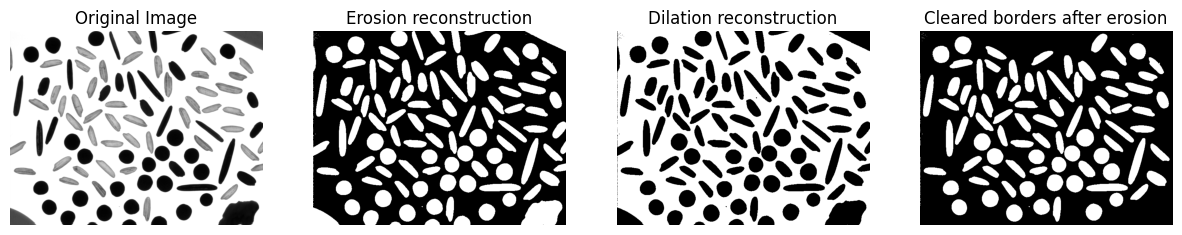

In [16]:
seed = np.copy(binary_grains)
seed[1:-1, 1:-1] = binary_grains.max()
mask = binary_grains

erosion_reconstr = morphology.reconstruction(seed, mask, method='erosion')

seed = np.copy(~binary_grains)
seed[1:-1, 1:-1] = (~binary_grains).min()
mask = ~binary_grains

dilation_reconstr = morphology.reconstruction(seed, mask, method='dilation')

f, axarr = plt.subplots(1,4,figsize=(15,8))
axarr[0].imshow(img_grains, cmap="gray")
axarr[0].set_title('Original Image')
axarr[0].axis('off')

axarr[1].imshow(erosion_reconstr, cmap="gray")
axarr[1].set_title('Erosion reconstruction')
axarr[1].axis('off')

axarr[2].imshow(dilation_reconstr, cmap="gray")
axarr[2].set_title('Dilation reconstruction')
axarr[2].axis('off')

clear_img = segmentation.clear_border(erosion_reconstr)
axarr[3].imshow(clear_img, cmap="gray")
axarr[3].set_title('Cleared borders after erosion')
axarr[3].axis('off')


## Feature extraction

Following code segments and labels distinct regions or objects within an image.

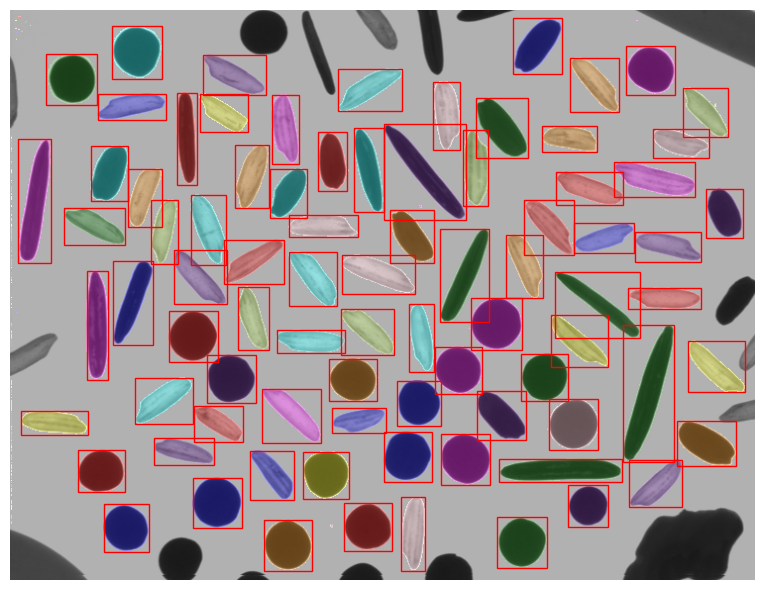

In [17]:
label_image = measure.label(clear_img)
image_label_overlay = color.label2rgb(label_image, image=img_grains, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

regions = measure.regionprops(label_image)

for region in regions:
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor='red',
            linewidth=1,
        )
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In the analysis of the input image, objects are categorized into four distinct grain types based on their shapes. The classification is as follows:

1. **Grain Type 1 (Circle):** Objects that closely resemble perfect circles, identified by a circularity range between 0.85 and 1.15. These are displayed in the top-left subplot with a count of 21 objects.

2. **Grain Type 2 (Ellipse 1):** Objects that exhibit elliptical shapes with a short axis-to-long axis ratio of less than 2.3. These are depicted in the top-right subplot with a count of 9 objects.

3. **Grain Type 3 (Ellipse 2):** Objects showing elliptical shapes with an axis ratio falling between 2.3 and 4. These are presented in the bottom-left subplot with a count of 43 objects.

4. **Grain Type 4 (Ellipse 3):** Objects that exhibit elliptical shapes with an axis ratio greater than or equal to 4. These are visualized in the bottom-right subplot with a count of 10 objects.

This categorization allows for a clear distinction between the various shapes of grains present in the image, providing valuable information for further analysis and processing of the grains.

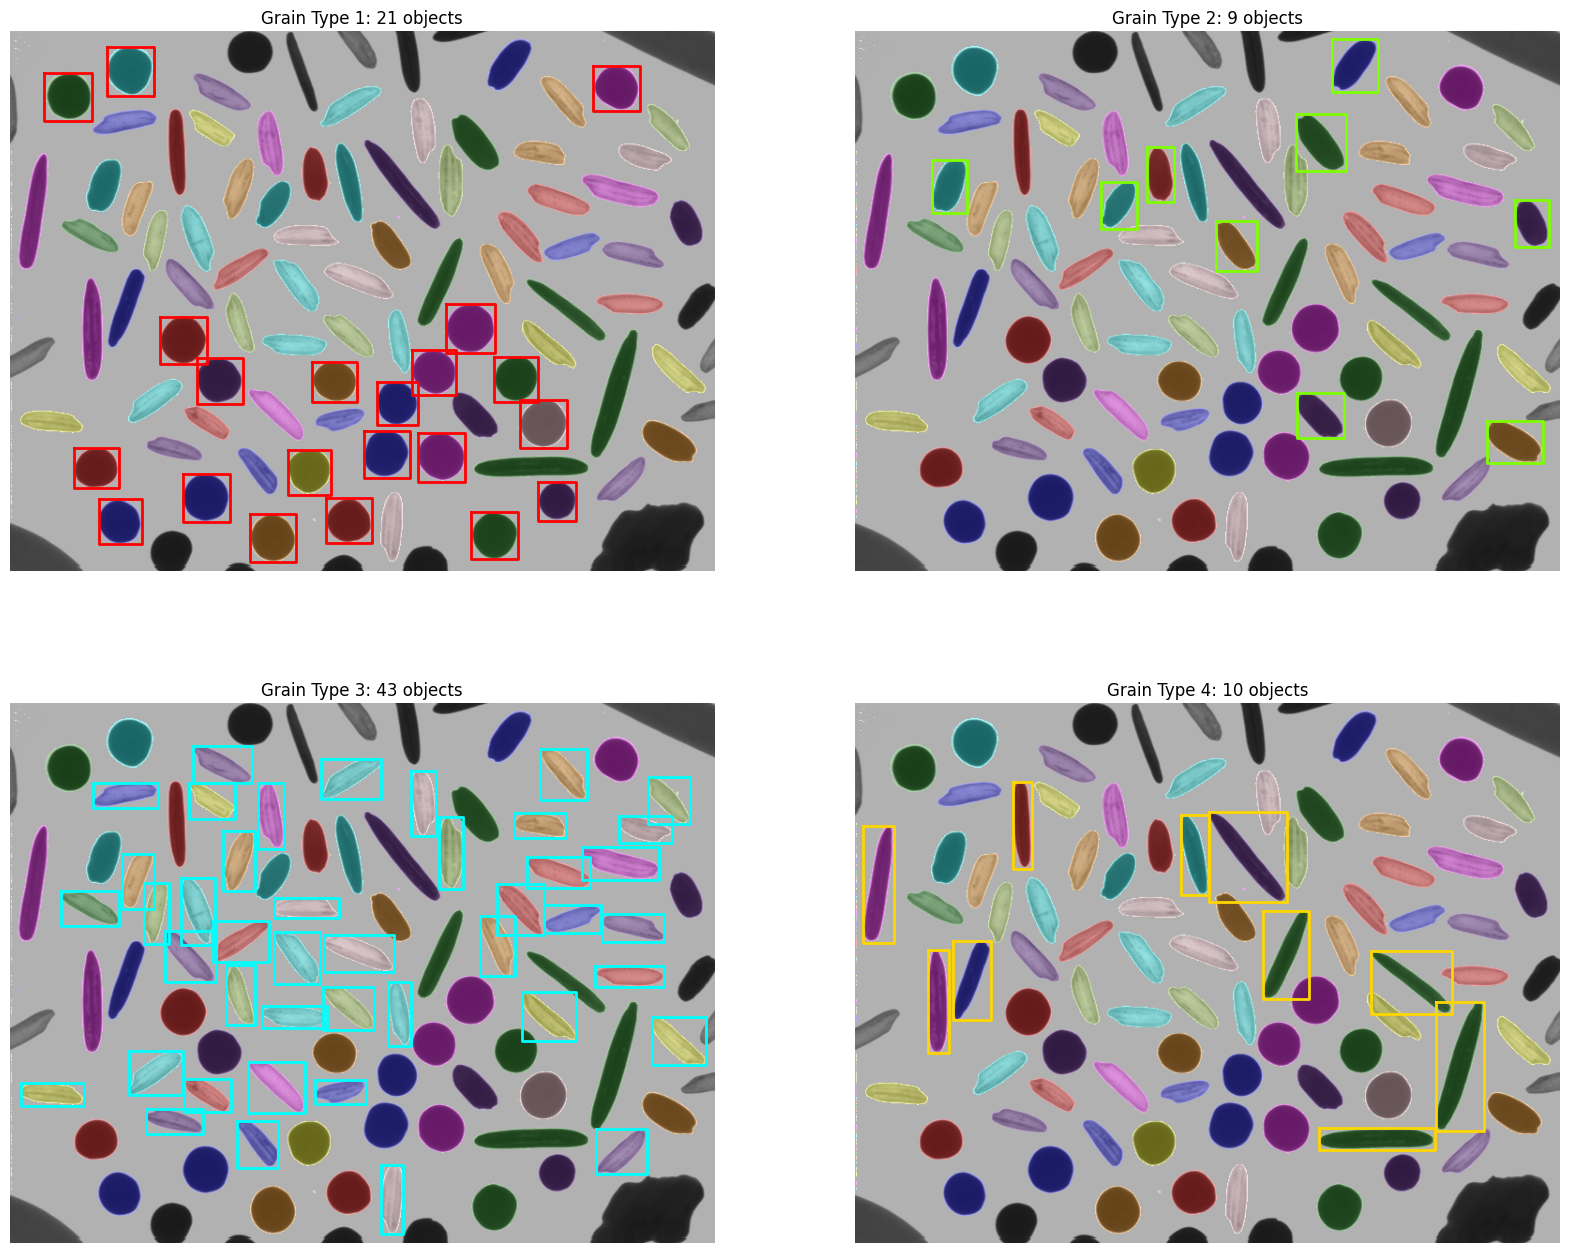

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(image_label_overlay)
ax[0][1].imshow(image_label_overlay)
ax[1][0].imshow(image_label_overlay)
ax[1][1].imshow(image_label_overlay)

# Initialize counters for each grain type
circle_count = 0
ellipse1_count = 0
ellipse2_count = 0
ellipse3_count = 0

# Iterate through the regions and detect circular shapes
for props in regions:
    if props.area <= 100:
        continue
        
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)

    # Define a circularity threshold (you can adjust this threshold)
    circularity = props.perimeter ** 2 / (4 * math.pi * props.area)

    if 0.85 < circularity < 1.15:  # Tune the circularity range as needed
        ax[0][0].plot(bx, by, 'r', linewidth=2)
        circle_count += 1
    else: 
        radius1 = math.sqrt((x1 - x0)**2 + (y1 - y0)**2) #short radius
        radius2 = math.sqrt((x2 - x0)**2 + (y2 - y0)**2) #long radius
        
        if radius2/radius1 < 2.3:
            ax[0][1].plot(bx, by, 'chartreuse', linewidth=2)
            ellipse1_count += 1
        elif 2.3 <= radius2/radius1 < 4:
            ax[1][0].plot(bx, by, 'cyan', linewidth=2)
            ellipse2_count += 1
        else:
            ax[1][1].plot(bx, by, 'gold', linewidth=2)
            ellipse3_count += 1

ax[0][0].set_title('Grain Type 1: {} objects'.format(circle_count))
ax[0][1].set_title('Grain Type 2: {} objects'.format(ellipse1_count))
ax[1][0].set_title('Grain Type 3: {} objects'.format(ellipse2_count))
ax[1][1].set_title('Grain Type 4: {} objects'.format(ellipse3_count))
    
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
plt.show()

In [19]:
# Calculate and print counts for each grain type
grain_counts = {
    "Grain Type 1 (Circle)": circle_count,
    "Grain Type 2 (Ellipse 1)": ellipse1_count,
    "Grain Type 3 (Ellipse 2)": ellipse2_count,
    "Grain Type 4 (Ellipse 3)": ellipse3_count,
}

print("Grain Counts:")
for grain_type, count in grain_counts.items():
    print(f"{grain_type}: {count}")


Grain Counts:
Grain Type 1 (Circle): 21
Grain Type 2 (Ellipse 1): 9
Grain Type 3 (Ellipse 2): 43
Grain Type 4 (Ellipse 3): 10
